# **Airbus Ship Detection Challenge**

![](https://www.kaggle.com/competitions/9988/images/header)

In [1]:
# Importing all neccessary libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import random
from keras import models, layers
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from skimage.io import imread

BATCH_SIZE = 16 # Size of batches
MAX_TRAIN_STEPS = 10 # Steps per epoch
MAX_VAL_STEPS = 10 # Validation steps
MAX_EPOCHS = 100 # Maximum amount of epochs

SAMPLES_PER_GROUP = 4000 # Amount of ships per image, f.e. 4k images where is 1 ship, 2 ships ...
LIMIT = int(1e2)
IMG_SCALING = (3, 3) # Since I downscaled train images to 256 x 256, needed to set the constant

BASE_DIR = 'airbus-ship-detection/'

TRAIN_PATH = BASE_DIR + 'train_v2/'
TEST_PATH = BASE_DIR + 'test_v2/'
MASKS_PATH = BASE_DIR + 'train_ship_segmentations_v2.csv'

MODEL_PATH = 'models/model.h5'


2024-07-18 12:08:49.305486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 12:08:49.305599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 12:08:49.416960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = os.listdir(TRAIN_PATH)
test = os.listdir(TEST_PATH)

print(f'Sz of train dataset : {len(train)} |{train[:LIMIT]}')
print(f'Sz of test dataset : {len(test)} |{test[:LIMIT]}')

Sz of train dataset : 192556 |['d8bc90fd6.jpg', 'ee783cf9f.jpg', '4b0d96146.jpg', '7c8d78c3f.jpg', '290f37d66.jpg', '6a91a5706.jpg', '43fa8864a.jpg', '018c1ff4d.jpg', 'a93de8732.jpg', 'e97cb9839.jpg', '30d3f7721.jpg', 'a1137f4a7.jpg', '0cd27e395.jpg', '08c5215b6.jpg', '1f6c6ee44.jpg', '43d5e047d.jpg', '75cac0232.jpg', 'b23c16f4e.jpg', '3ff2c6cd5.jpg', '208de942c.jpg', 'c3f2fcbe9.jpg', '84c7ff904.jpg', '16bb16e1f.jpg', 'fa272c615.jpg', '949c0be4b.jpg', '4ea891205.jpg', 'b00360819.jpg', 'a7f83e6ff.jpg', '9ea4637e5.jpg', '00f65e651.jpg', 'cfe5eb779.jpg', '5023a7fd6.jpg', '60e9a5481.jpg', 'f0feb288d.jpg', 'dcfaa80e6.jpg', 'e3343462c.jpg', '3bef60e0a.jpg', '68c09e839.jpg', '2cb65c09d.jpg', '8ac59b624.jpg', 'ebc0132ee.jpg', '4758d0b53.jpg', '3e3c7052b.jpg', '9bdbf2898.jpg', '1024758b1.jpg', '232f389a5.jpg', '8d804f550.jpg', 'a30a1c8d9.jpg', '6f95e5350.jpg', '1421e7747.jpg', '91902fcf3.jpg', '6d790b122.jpg', '0d5e736dd.jpg', '773af8c06.jpg', '3d28d4a07.jpg', '53c26052e.jpg', 'bc64f4780.jpg', 

### Since position of ships on photos are encoded in run-length encoding, here's implemented utility functions, such as **encoding, decoding, and converting encoded** pixels to mask 

In [3]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape = (768,768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T # Need to transpose to match the dimensions


In [4]:
def concat_mask(mask_list):
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1) # Expanding dimensions, so don't need to do it while generating batchess

### Below I did some EDA to analyse the dataset

In [5]:
masks = pd.read_csv(os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
masks.drop(['ships'], axis=1, inplace=True)

81723 masks in 42556 images
150000 empty images in 192556 total images


In [6]:
print(f'Total amount of unique photos: {len(masks.ImageId.unique())}')

Total amount of unique photos: 192556


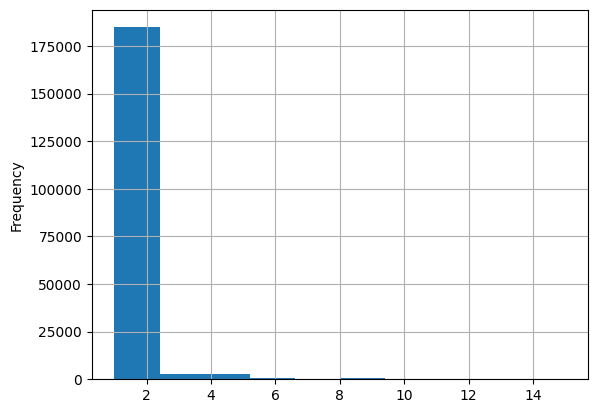

In [7]:
masks.ImageId.value_counts().plot.hist().grid(True)

### As we can see, the dataset is really unbalanced, there is **more than 90%** of images without ships

/tmp/ipykernel_34/1973516858.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)


19778 masks


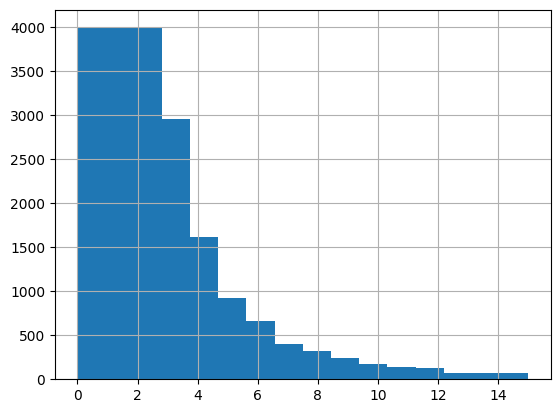

In [8]:
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins = balanced_train_df['ships'].max() + 1)
print(balanced_train_df.shape[0], 'masks')

In [9]:
balanced_train_df

ImageId  ships  has_ship
ships                                       
0     134062  b24208d86.jpg      0       0.0
      8567    0b595b468.jpg      0       0.0
      176561  ead7ad924.jpg      0       0.0
      3766    05132b70b.jpg      0       0.0
      144422  c0100da89.jpg      0       0.0
...                     ...    ...       ...
15    176401  ea9f82665.jpg     15       1.0
      179547  eec04e7a8.jpg     15       1.0
      186407  f7e6819bb.jpg     15       1.0
      190392  fd1de824c.jpg     15       1.0
      192184  ff7ac7f3c.jpg     15       1.0

[19778 rows x 3 columns]

### Split dataset into train and validation data using **ski-kit learn library**

In [11]:
train_ships, valid_ships = train_test_split(balanced_train_df, test_size = 0.2, stratify = balanced_train_df.ships)
train_ships

,,ImageId,ships,has_ship
ships,,,,
1,139178,b8ed9f347.jpg,1,1.0
0,98163,82971797a.jpg,0,0.0
5,181686,f1a22ed2b.jpg,5,1.0
1,1186,018b8ef33.jpg,1,1.0
2,68791,5b8d4908d.jpg,2,1.0
...,...,...,...,...
0,32596,2b4c40d0a.jpg,0,0.0
4,97449,8193a272a.jpg,4,1.0
1,28019,253f2c0ba.jpg,1,1.0


In [12]:
# Merging together to get back some images
train_df = pd.merge(masks, train_ships)
valid_df = pd.merge(masks, valid_ships)

In [13]:
valid_df.ships.value_counts()

ships
3     1773
2     1600
4     1296
5      925
1      800
0      800
6      786
7      567
8      512
9      441
10     340
11     319
12     300
14     210
13     195
15     195
Name: count, dtype: int64

In [14]:
train_df.ships.value_counts()

ships
3     7089
2     6400
4     5192
5     3700
0     3200
1     3200
6     3156
7     2275
8     2032
9     1746
10    1340
11    1265
12    1188
14     854
15     795
13     780
Name: count, dtype: int64

In [15]:
train_df.shape, valid_df.shape

((44212, 4), (11059, 4))

### Dataset looks much better, let's take a look on random image and mask

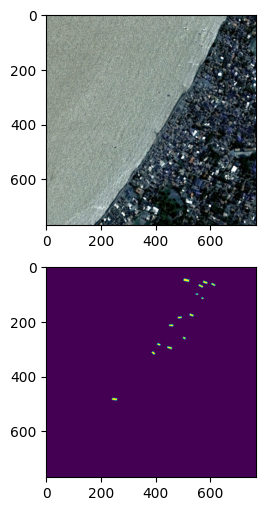

In [16]:
random_img = random.choice(train_df.ImageId)

test_masks = masks[masks.ImageId == random_img]
msk = concat_mask(list(test_masks.EncodedPixels))

img = cv.imread(TRAIN_PATH + random_img)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].imshow(img)
axes[1].imshow(msk)

## Creating U-Net Convolutional Neural Network

### As i said earlier, I am goind to reshape (downscale) images to get better RAM efficiency

In [17]:
def UnetCNN(input_size = (256, 256, 3)):
    inputs = layers.Input(input_size)

    C1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    C1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C1)
    P1 = layers.MaxPooling2D((2, 2))(C1)

    C2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P1)
    C2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C2)
    P2 = layers.MaxPooling2D((2, 2))(C2)

    C3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P2)
    C3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C3)
    P3 = layers.MaxPooling2D((2, 2))(C3)

    C4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P3)
    C4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C4)
    P4 = layers.MaxPooling2D(pool_size=(2, 2))(C4)

    C5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P4)
    C5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C5)

    U6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(C5)
    U6 = layers.concatenate([U6, C4])
    C6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U6)
    C6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C6)

    U7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(C6)
    U7 = layers.concatenate([U7, C3])
    C7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U7)
    C7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C7)

    U8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(C7)
    U8 = layers.concatenate([U8, C2])
    C8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U8)
    C8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C8)

    U9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(C8)
    U9 = layers.concatenate([U9, C1], axis=3)
    C9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U9)
    C9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C9)

    D = layers.Conv2D(1, (1, 1), activation='sigmoid')(C9)
    
    seg_model = models.Model(inputs=[inputs], outputs=[D])
    
    return seg_model

built_model = UnetCNN()
built_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

## We have ~2 million trainable parameters, which is fine

### Code below generates batches of size *BATCH_SIZE*. We read both images and mask and yielding them , so the function will behave as generator.

In [18]:
def batch_data(batch_sz, batch_imgs, masks):
    imgs = []
    msks = []

    for img_name in batch_imgs:
        img = imread(os.path.join(TRAIN_PATH, img_name))
        msk = concat_mask(masks[masks['ImageId'] == img_name]['EncodedPixels'])

        img = img[::IMG_SCALING[0], ::IMG_SCALING[1]]
        msk = msk[::IMG_SCALING[0], ::IMG_SCALING[1]]

        imgs.append(img)
        msks.append(msk)

        if len(imgs) >= batch_sz:
            yield np.stack(imgs, 0) / 255.0, np.stack(msks, 0).astype(np.float32)
            imgs, msks = [], []

In [19]:
train_dfrm = batch_data(BATCH_SIZE, train_df['ImageId'], masks)
valid_dfrm = batch_data(BATCH_SIZE, valid_df['ImageId'], masks)

img, msk = next(batch_data(BATCH_SIZE, train_df['ImageId'], masks))
img.shape, msk.shape

((16, 256, 256, 3), (16, 256, 256, 1))

### Let's see if our generator works correctly

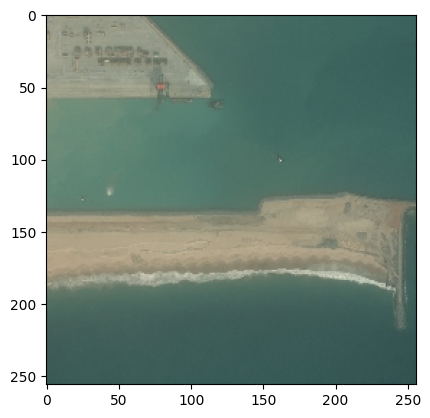

In [20]:
plt.imshow(img[1])

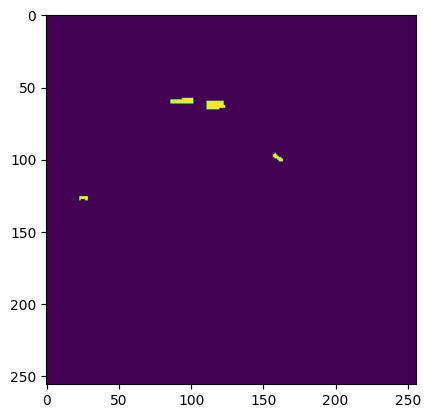

In [21]:
plt.imshow(msk[1])

### Yes, it works! Next step is choosing the callbacks for our model. After reading some forums and guides, I decied to choose **ModelCheckpoint, reduceLearningRate, and EarlyStopping** as those seemed the most optimal

In [22]:
weight_path = 'weights/{}.weights.h5'.format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=3, verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_dice_coef", mode="max", patience=15)

callbacks_list = [checkpoint, early, reduceLROnPlat]

### Some custom metrics, that can be easily found in the Intennet. Main metrics is FocalLoss and binary_accuracy. For optimizer I chose Adam as majority stopped at Adam over common SGD 

In [23]:
def FocalLoss(targets, inputs, alpha = 0.8, gamma = 2):    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1 - BCE_EXP), gamma) * BCE)
    
    return focal_loss

def DiceBCELoss(targets, inputs, smooth=1e-6):    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.dot(K.transpose(targets), inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def DiceLoss(targets, inputs, smooth=1e-6):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice


built_model.compile(optimizer=Adam(1e-3), loss = FocalLoss, metrics=[dice_coef, 'binary_accuracy']) 

### Training the model

In [24]:
history = built_model.fit(
    train_dfrm,
    validation_data = valid_dfrm,
    callbacks = callbacks_list,
    verbose = 1,
    epochs = min(10, MAX_EPOCHS),
    steps_per_epoch = 10,
    validation_steps = 10
    )

Epoch 1/10
 1/10 ━━━━━━━━━━━━━━━━━━━━ 5:44 38s/step - binary_accuracy: 0.9980 - dice_coef: 0.0043 - loss: 0.0329

I0000 00:00:1721305988.797828     673 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - binary_accuracy: 0.9935 - dice_coef: 0.0088 - loss: 0.0302
Epoch 1: saving model to /kaggle/working/seg_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - binary_accuracy: 0.9934 - dice_coef: 0.0089 - loss: 0.0296 - val_binary_accuracy: 0.9935 - val_dice_coef: 0.0090 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - binary_accuracy: 0.9912 - dice_coef: 0.0128 - loss: 0.0190
Epoch 2: saving model to /kaggle/working/seg_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_accuracy: 0.9912 - dice_coef: 0.0132 - loss: 0.0189 - val_binary_accuracy: 0.9926 - val_dice_coef: 0.0170 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - binary_accuracy: 0.9938 - dice_coef: 0.0149 - loss: 0.0143
Epoch 3: saving model to /kaggle/working/seg_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_accuracy: 0.9936 - dice_coef: 0.0156 - loss:

In [25]:
built_model.load_weights(weight_path)
built_model.save('models/model.h5')

In [26]:
model = models.load_model(MODEL_PATH, compile = False)

In [27]:
def gen_pred(img, model):
    rgb_path = os.path.join(TEST_PATH, img)
    img = cv.imread(rgb_path)
    img = img[::IMG_SCALING[0], ::IMG_SCALING[1]]
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img / 255
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred, axis=0)
    return cv.imread(rgb_path), pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


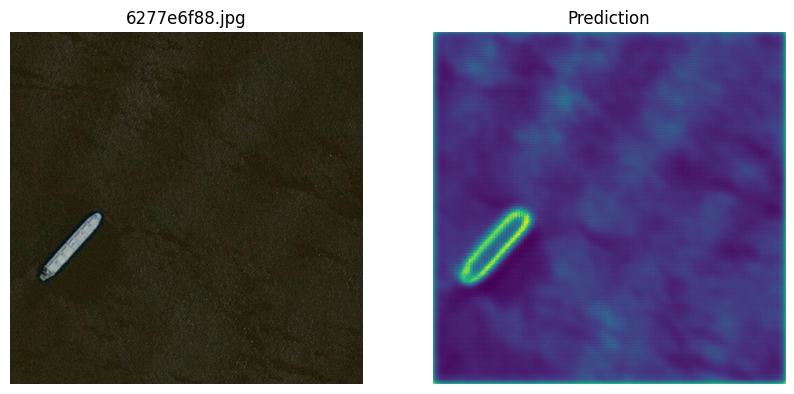

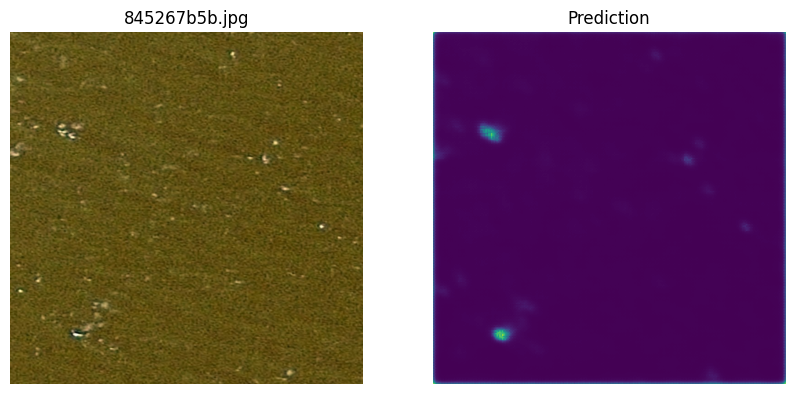

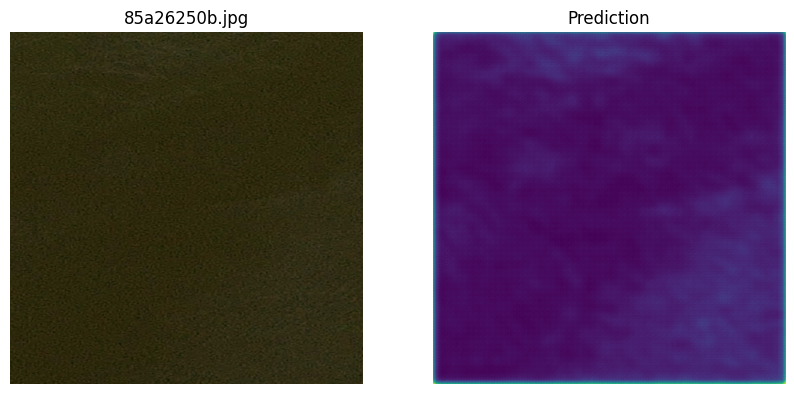

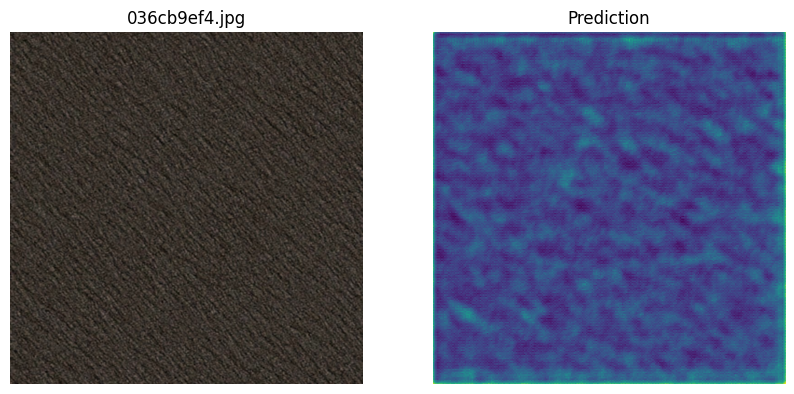

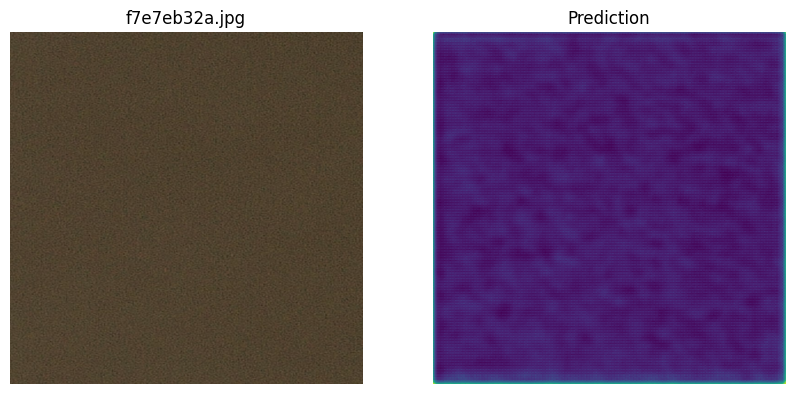

In [32]:
rows = 1
columns = 2

test_imgs = [random.choice(os.listdir(TEST_PATH)) for _ in range(5)]

for i in range(len(test_imgs)):
    img, pred = gen_pred(test_imgs[i], model)
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{test_imgs[i]}')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(pred, interpolation = None)
    plt.axis('off')
    plt.title("Prediction")